# Predicting Flight Arrival Delays
### By Nick Palacio

# Intro
## Problem Statement
The logistics of predicting airline flight delays can be incredibly complex. It can depend on many different variables: airline company, time of year, departure time, etc. This is a worthwhile problem to solve for airlines because if a flight will be arriving late it could have a chain reaction on other flights that are using the same airplane or crew which can be costly. This is a worthwhile problem to solve for passengers so that if a flight is going to be late they can plan accordingly. The sooner both of these stakeholders know about a delayed flight the better.
## Existing Techniques
Several machine learning methods have been employed to solve this very problem. A paper published in 2016 (found here https://ieeexplore.ieee.org/abstract/document/7777956) talks about using decision trees, random forests, and the AdaBoost algorithm to try and predict flight delays. However, they turned it into a binary classification problem to simply say if a flight would be late or not. Another paper also published in 2016 (found here https://ieeexplore.ieee.org/abstract/document/7778092) used Deep Learning to try and predict flight delays.
## My Approach
My approach to this problem will involve comparing several different machine learning algorithms on a dataset of flight and weather information from Microsoft’s Azure Machine Learning Studio. The algorithm’s I will compare are Linear Regression and Decision Trees. Originally, I wanted to use the Support Vector Machine algorithm but I ran into some computational limits due to the size of the datasets. I will also compare the model performances with and without an additional weather dataset that ties an airport to weather conditions at a point in time.
## Process
First I will load the flight dataset from a CSV file. Then I will clean it up and take a look at a few features that might be useful in our models. After this I will build the machine learning models using the algorithms described above. Then I will compare the models using several error metrics described later on. Once I have done all of this without the weather dataset I will load that from a CSV file, clean it and join it to our original flight dataset. Using this new joined dataset I will run the same algorithms and again compare their error metrics. Then I will compare the error metrics of the algorithms with and without the weather dataset to see how much of a difference it made.
## Tools
In order to conduct this experiment I will use the Pandas python library and the NumPy python library for importing/cleaning/analyzing data. I will use the SciKit-Learn python library for creating the machine learning models. I have also written a small utility (utils.py) library to reduce duplicate code throughout this notebook.

## Constants

In [2]:
flightDataFile = './Flight Delays Data.csv'
weatherDataFile = './Weather Data.csv'
trainingDataPercent = .70

In [3]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import tree

## Without Weather Data

### Load Flight Data

In [4]:
flightData = pd.read_csv(flightDataFile)
flightData

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0.0,0.0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0.0,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0.0,0.0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1.0,0.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0.0,0.0
5,2013,4,19,5,DL,10397,15016,1726,-1.0,0.0,1818,-19.0,0.0,0.0
6,2013,4,19,5,DL,15016,10397,1900,0.0,0.0,2133,-1.0,0.0,0.0
7,2013,4,19,5,DL,10397,14869,2145,15.0,1.0,2356,24.0,1.0,0.0
8,2013,4,19,5,DL,10397,10423,2157,33.0,1.0,2333,34.0,1.0,0.0
9,2013,4,19,5,DL,11278,10397,1900,323.0,1.0,2055,322.0,1.0,0.0


Here we are loading the flight delays dataset from a CSV file. This dataset is a sample dataset from Microsoft. It contains flight delay data from the U.S. Department of Transportation. The data spans from April to October 2013. It was also filtered to only contain data from the 70 busiest airports in the continental U.S. It contains ~2.7 million records. Each record specifies the origin and destination airports, airline company as well as the date and time of the departure and arrival of the flight. The column we will be training our model to predict is 'ArrDelay' which says how many minutes late (or early) a flight was from arriving at its destination airport.

### Clean Flight Data

If we just tried to run our algorithms on this dataset right now we would run into a few problems. Probably the most time consuming part of the machine learning problem solving process is cleaning and analyzing the data. We will proceed with cleaning our data by filling it missing values, getting rid of duplicate records and filtering out columns we do not want.

#### Missing Data

In [5]:
utils.FillInMissingNumericValues(flightData,'DepDelay',0)
utils.FillInMissingNumericValues(flightData,'ArrDelay',0)

Filled in 27444 missing values for DepDelay
Filled in 29033 missing values for ArrDelay


Two columns in our dataset have some missing data. 'DepDelay' says how many minutes late a flight was from departing its origin airport. 'ArrDelay' is our label we are trying to predict, how many minutes late a flight was. We will substitute 0 for any missing values in these columns. We will do this by calling the utility library which in turn uses Pandas to fill in the missing values and print out how many there were.

#### Duplicate Rows

In [6]:
utils.DropDuplicates(flightData,['Year','Month','DayofMonth','Carrier','OriginAirportID','DestAirportID','CRSDepTime','CRSArrTime'])

Deleted 21 duplicate rows


- what makes a row unique?
- drops duplicates using pandas and prints how many it dropped
There are duplicate records the

#### Filter Columns

In [7]:
filteredFlightData = utils.FilterColumns(flightData, ['Year','Month','DayofMonth','DayOfWeek','Carrier','OriginAirportID','DestAirportID','CRSDepTime','DepDelay'])
filteredFlightData

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay
0,2013,4,19,5,DL,11433,13303,837,-3.0
1,2013,4,19,5,DL,14869,12478,1705,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0
3,2013,4,19,5,DL,15016,11433,1630,28.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0
5,2013,4,19,5,DL,10397,15016,1726,-1.0
6,2013,4,19,5,DL,15016,10397,1900,0.0
7,2013,4,19,5,DL,10397,14869,2145,15.0
8,2013,4,19,5,DL,10397,10423,2157,33.0
9,2013,4,19,5,DL,11278,10397,1900,323.0


- uses call to pandas to filter columns
- talk about columns we are dropping and why (arrDelay15, cancelled)

#### Handle Categorical Data

In [8]:
pristineFlightData = pd.get_dummies(filteredFlightData,columns=['Carrier','OriginAirportID','DestAirportID'])

- why do we need to convert categorical data

### Analyze Flight Data Features

- fundamental part of ML problem solving
- want to find features we might think are important

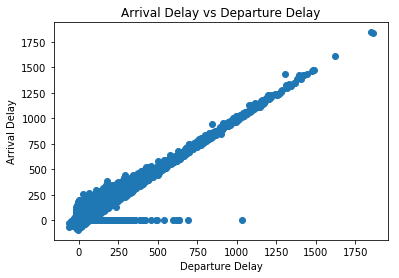

In [9]:
arrDelayData = flightData['ArrDelay']
depDelayData = flightData['DepDelay']
plt.scatter(depDelayData, arrDelayData)
plt.xlabel('Departure Delay')
plt.ylabel('Arrival Delay')
plt.title('Arrival Delay vs Departure Delay')
plt.show()

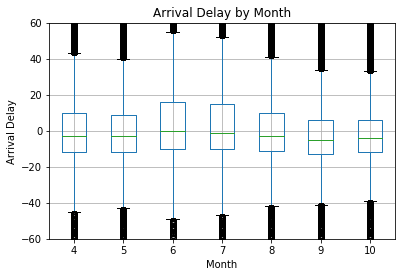

In [10]:
ax = flightData.boxplot('ArrDelay',by='Month',return_type=None)
ax.set_ylim(-60,60)
plt.axes(ax)
plt.ylabel('Arrival Delay')
plt.xlabel('Month')
plt.title('Arrival Delay by Month')
plt.suptitle('')
plt.show()

- seems to be some correlation between month and arrival delay
- restricted view for more meaningful interpretation

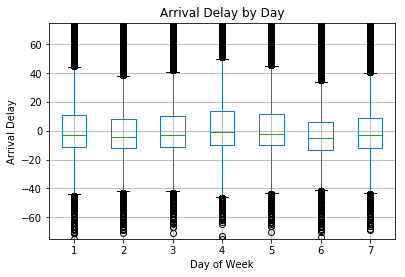

In [11]:
ax = flightData.boxplot('ArrDelay',by='DayOfWeek',return_type=None)
ax.set_ylim(-75,75)
plt.axes(ax)
plt.ylabel('Arrival Delay')
plt.xlabel('Day of Week')
plt.title('Arrival Delay by Day')
plt.suptitle('')
plt.show()

- some correlation between day of week and arrival delay
- restricted view

### Run Algorithms

- ready to run algos
- need to split data into training and testing

In [12]:
mask = np.random.rand(len(pristineFlightData)) < trainingDataPercent
trainingDataX = pristineFlightData[mask]
testingDataX = pristineFlightData[~mask]
labelData = flightData.filter(items=['ArrDelay'])
trainingLabelData = labelData[mask]
testingLabelData = labelData[~mask]

- splitting up data into testing and training datasets randomly

In [13]:
comparisonDict = {
    'MeanAbsErr': [],
    'MeanSquErr': [],
    'RootMeanSquErr': []
}

- talk about error metrics

#### Linear Regression

- brief explanation of linear regression
- why it might be useful here

In [14]:
linRegrModel = LinearRegression()
linRegrModel.fit(trainingDataX,trainingLabelData)
predictedLRLabelData = linRegrModel.predict(testingDataX)

- train the model
- have it predict the testing data

In [15]:
comparisonDict = utils.UpdateComparisonDict(comparisonDict, testingLabelData, predictedLRLabelData)
comparisonDict

{'MeanAbsErr': [8.809185249234588],
 'MeanSquErr': [168.5921879424946],
 'RootMeanSquErr': [12.98430544705779]}

- calculate our error metrics and save them off

#### Decision Tree Regression

- brief explanation of decision tree algorithm and why it might be useful here

In [16]:
dtModel = tree.DecisionTreeRegressor()
dtModel.fit(trainingDataX,trainingLabelData)
predictedDTLabelData = dtModel.predict(testingDataX)

- train the model
- have it predict our testing data

In [44]:
comparisonDict = utils.UpdateComparisonDict(comparisonDict, testingLabelData, predictedDTLabelData)
comparisonDict

{'MeanAbsErr': [8.809185249234588, 11.883970579221575],
 'MeanSquErr': [168.5921879424946, 305.45907508427825],
 'RootMeanSquErr': [12.98430544705779, 17.47738753602146]}

- again, save off error calculations

- talk about exclusion of SVM algorithm (dataset too large)

### Comparison of Algorithms Without Weather Data

In [18]:
algorithms = ('LR', 'DT')
y_pos = np.arange(len(algorithms))

- LR = linear regre, DT = decision tree

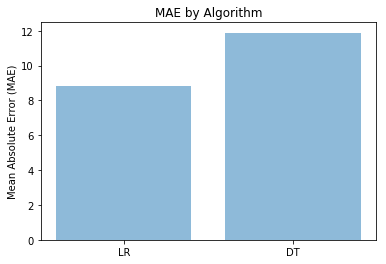

In [19]:
plt.bar(y_pos, comparisonDict['MeanAbsErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE by Algorithm')
plt.show()

- on average, we aim a little higher (say planes will be later than they are)

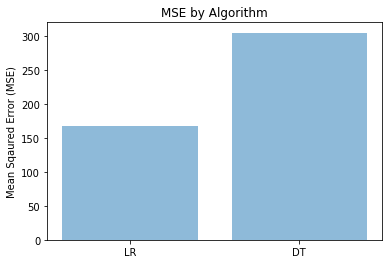

In [20]:
plt.bar(y_pos, comparisonDict['MeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Sqaured Error (MSE)')
plt.title('MSE by Algorithm')
plt.show()

- we expect the square of errors to show larger difference

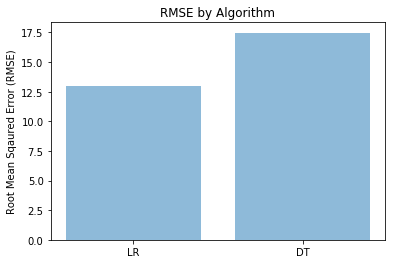

In [21]:
plt.bar(y_pos, comparisonDict['RootMeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Root Mean Sqaured Error (RMSE)')
plt.title('RMSE by Algorithm')
plt.show()

- most interested in this metric because it squares negatives, abs error does not
- on average we are x minutes off (high or low)

## With Weather Data

### Load Weather Data

In [22]:
weatherData = pd.read_csv(weatherDataFile)

C:\Users\Nick\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


- explain data source
- explain columns

### Clean Weather Data

- issues with data (missing values, correlated columns, duplicates)

#### Missing Data

In [23]:
colInfoDictArr = [
    {'name': 'Visibility','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'DryBulbCelsius','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'WetBulbCelsius','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'DewPointCelsius','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'RelativeHumidity','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'WindSpeed','valuesToHandle': ['M','  '],'defaultValue': 0},
    {'name': 'StationPressure','valuesToHandle': ['M'],'defaultValue': 0}
]
processedWeatherData = utils.ConvertColumnsToNumeric(weatherData, colInfoDictArr)
processedWeatherData

,AirportID,Year,Month,Day,Time,TimeZone,SkyCondition,Visibility,WeatherType,DryBulbFarenheit,...,WindSpeed,WindDirection,ValueForWindCharacter,StationPressure,PressureTendency,PressureChange,SeaLevelPressure,RecordType,HourlyPrecip,Altimeter
0,14843,2013,4,1,56,-4,FEW018 SCT044 BKN070,10.0,-RA,76,...,13.0,080,,30.06,,,30.06,AA,T,30.07
1,14843,2013,4,1,156,-4,FEW037 SCT070,10.0,,76,...,10.0,090,,30.05,6,017,30.05,AA,,30.06
2,14843,2013,4,1,256,-4,FEW037 SCT070,10.0,,76,...,9.0,100,,30.03,,,30.03,AA,,30.04
3,14843,2013,4,1,356,-4,FEW025 SCT070,10.0,,76,...,9.0,100,,30.02,,,30.03,AA,,30.03
4,14843,2013,4,1,456,-4,FEW025,10.0,,76,...,7.0,110,,30.03,5,004,30.04,AA,,30.04
5,14843,2013,4,1,556,-4,FEW025 SCT080,10.0,,76,...,7.0,100,,30.04,,,30.05,AA,,30.05
6,14843,2013,4,1,656,-4,FEW028 BKN080,10.0,,77,...,9.0,110,,30.07,,,30.07,AA,,30.08
7,14843,2013,4,1,756,-4,FEW028 BKN080,10.0,,79,...,13.0,100,,30.09,3,020,30.10,AA,,30.10
8,14843,2013,4,1,856,-4,FEW030 BKN080,10.0,,82,...,14.0,100,21,30.11,,,30.11,AA,,30.12
9,14843,2013,4,1,956,-4,SCT035 BKN090,10.0,,83,...,16.0,090,23,30.11,,,30.12,AA,,30.12


- pandas does not know the data type of our columns due to missing data or data in wrong data type
- fill in all these missing values
- iterates over all rows, converts all 'valuesToHandle' to 'defaultValue'

In [24]:
processedWeatherData = utils.UpdateWeatherDataTimeFields(weatherData)

- we use time zone to adjust actual times for the join later
- create datetime object, add in time zone adjustment, get new date time fields

#### Filter Columns

In [25]:
processedWeatherData = utils.FilterColumns(processedWeatherData, ['AirportID','Year','Month','Day','Time','Hour','TimeZone','Visibility','DryBulbCelsius','WetBulbCelsius','DewPointCelsius','RelativeHumidity','WindSpeed','StationPressure'])
processedWeatherData

,AirportID,Year,Month,Day,Time,Hour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,14843,2013,3,31,56,20,-4,10.0,24.4,23.3,22.8,90.0,13.0,30.06
1,14843,2013,3,31,156,21,-4,10.0,24.4,22.5,21.7,85.0,10.0,30.05
2,14843,2013,3,31,256,22,-4,10.0,24.4,22.5,21.7,85.0,9.0,30.03
3,14843,2013,3,31,356,23,-4,10.0,24.4,22.2,21.1,82.0,9.0,30.02
4,14843,2013,4,1,456,0,-4,10.0,24.4,22.2,21.1,82.0,7.0,30.03
5,14843,2013,4,1,556,1,-4,10.0,24.4,21.8,20.6,79.0,7.0,30.04
6,14843,2013,4,1,656,2,-4,10.0,25.0,21.7,20.0,74.0,9.0,30.07
7,14843,2013,4,1,756,3,-4,10.0,26.1,22.4,20.6,72.0,13.0,30.09
8,14843,2013,4,1,856,4,-4,10.0,27.8,22.9,20.6,65.0,14.0,30.11
9,14843,2013,4,1,956,5,-4,10.0,28.3,23.0,20.6,63.0,16.0,30.11


- explain what columns we dropped

#### Drop Duplicate Weather Records

In [26]:
utils.DropDuplicates(processedWeatherData, ['AirportID','Year','Month','Day','Hour'])

Deleted 67763 duplicate rows


- what makes a record unique?
- uses same pandas call to drop duplicates

### Join Flight Data with Weather Data

- explain how we will join the data (columns, left join)

In [27]:
filteredFlightData['CRSDepHour'] = flightData.apply(lambda row: utils.CalculateFlightDataHour(row),axis=1)

- for flight dep hour we just round down the time to its hour

In [28]:
mergedData = filteredFlightData.merge(processedWeatherData,how='left', left_on=['OriginAirportID','Year','Month','DayofMonth','CRSDepHour'], right_on=['AirportID','Year','Month','Day','Hour'])
mergedData

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSDepHour,...,Time,Hour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,2013,4,19,5,DL,11433,13303,837,-3.0,8,...,1353.0,8.0,-5.0,10.0,6.1,3.1,-1.1,60.0,34.0,28.89
1,2013,4,19,5,DL,14869,12478,1705,0.0,17,...,53.0,17.0,-7.0,10.0,7.8,6.6,5.6,86.0,0.0,25.71
2,2013,4,19,5,DL,14057,14869,600,-4.0,6,...,1453.0,6.0,-8.0,10.0,13.9,11.5,9.4,75.0,9.0,30.09
3,2013,4,19,5,DL,15016,11433,1630,28.0,16,...,2251.0,16.0,-6.0,10.0,5.6,1.8,-3.9,51.0,7.0,29.31
4,2013,4,19,5,DL,11193,12892,1615,-6.0,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013,4,19,5,DL,10397,15016,1726,-1.0,17,...,2252.0,17.0,-5.0,10.0,7.8,5.5,2.8,71.0,10.0,28.95
6,2013,4,19,5,DL,15016,10397,1900,0.0,19,...,151.0,19.0,-6.0,10.0,3.9,1.2,-2.8,62.0,6.0,29.35
7,2013,4,19,5,DL,10397,14869,2145,15.0,21,...,252.0,21.0,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
8,2013,4,19,5,DL,10397,10423,2157,33.0,21,...,252.0,21.0,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
9,2013,4,19,5,DL,11278,10397,1900,323.0,19,...,52.0,19.0,-5.0,10.0,11.7,9.4,7.2,74.0,8.0,29.75


- do left join on our join columns we made

In [29]:
# TODO: analyze dataset with weather features

#### Drop Columns

In [30]:
mergedData = utils.FilterColumns(mergedData, ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier','OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepDelay','CRSDepHour','ArrDelay','TimeZone','Visibility','DryBulbCelsius','WetBulbCelsius','DewPointCelsius','RelativeHumidity','WindSpeed','StationPressure'])
mergedData

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSDepHour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,2013,4,19,5,DL,11433,13303,837,-3.0,8,-5.0,10.0,6.1,3.1,-1.1,60.0,34.0,28.89
1,2013,4,19,5,DL,14869,12478,1705,0.0,17,-7.0,10.0,7.8,6.6,5.6,86.0,0.0,25.71
2,2013,4,19,5,DL,14057,14869,600,-4.0,6,-8.0,10.0,13.9,11.5,9.4,75.0,9.0,30.09
3,2013,4,19,5,DL,15016,11433,1630,28.0,16,-6.0,10.0,5.6,1.8,-3.9,51.0,7.0,29.31
4,2013,4,19,5,DL,11193,12892,1615,-6.0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013,4,19,5,DL,10397,15016,1726,-1.0,17,-5.0,10.0,7.8,5.5,2.8,71.0,10.0,28.95
6,2013,4,19,5,DL,15016,10397,1900,0.0,19,-6.0,10.0,3.9,1.2,-2.8,62.0,6.0,29.35
7,2013,4,19,5,DL,10397,14869,2145,15.0,21,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
8,2013,4,19,5,DL,10397,10423,2157,33.0,21,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
9,2013,4,19,5,DL,11278,10397,1900,323.0,19,-5.0,10.0,11.7,9.4,7.2,74.0,8.0,29.75


- need to drop the columns we joined on in weather dataset since it is duplicated

#### Missing Data from Join 

In [31]:
utils.FillInMissingNumericValues(mergedData, 'TimeZone',0)
utils.FillInMissingNumericValues(mergedData, 'Visibility',0)
utils.FillInMissingNumericValues(mergedData, 'DryBulbCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'WetBulbCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'DewPointCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'RelativeHumidity',0)
utils.FillInMissingNumericValues(mergedData, 'WindSpeed',0)
utils.FillInMissingNumericValues(mergedData, 'StationPressure',0)
mergedData

Filled in 287341 missing values for TimeZone
Filled in 287341 missing values for Visibility
Filled in 287341 missing values for DryBulbCelsius
Filled in 287341 missing values for WetBulbCelsius
Filled in 287341 missing values for DewPointCelsius
Filled in 287341 missing values for RelativeHumidity
Filled in 287341 missing values for WindSpeed
Filled in 287341 missing values for StationPressure


,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSDepHour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,2013,4,19,5,DL,11433,13303,837,-3.0,8,-5.0,10.0,6.1,3.1,-1.1,60.0,34.0,28.89
1,2013,4,19,5,DL,14869,12478,1705,0.0,17,-7.0,10.0,7.8,6.6,5.6,86.0,0.0,25.71
2,2013,4,19,5,DL,14057,14869,600,-4.0,6,-8.0,10.0,13.9,11.5,9.4,75.0,9.0,30.09
3,2013,4,19,5,DL,15016,11433,1630,28.0,16,-6.0,10.0,5.6,1.8,-3.9,51.0,7.0,29.31
4,2013,4,19,5,DL,11193,12892,1615,-6.0,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5,2013,4,19,5,DL,10397,15016,1726,-1.0,17,-5.0,10.0,7.8,5.5,2.8,71.0,10.0,28.95
6,2013,4,19,5,DL,15016,10397,1900,0.0,19,-6.0,10.0,3.9,1.2,-2.8,62.0,6.0,29.35
7,2013,4,19,5,DL,10397,14869,2145,15.0,21,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
8,2013,4,19,5,DL,10397,10423,2157,33.0,21,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
9,2013,4,19,5,DL,11278,10397,1900,323.0,19,-5.0,10.0,11.7,9.4,7.2,74.0,8.0,29.75


- need to fill in weather values for flights that could not be joined
- same method as before, 0 for all missing values

#### Handle Categorical Data

In [32]:
mergedData = pd.get_dummies(mergedData,columns=['Carrier','OriginAirportID','DestAirportID','TimeZone'])
mergedData

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSDepHour,Visibility,DryBulbCelsius,WetBulbCelsius,...,DestAirportID_15304,DestAirportID_15376,TimeZone_-10.0,TimeZone_-9.0,TimeZone_-8.0,TimeZone_-7.0,TimeZone_-6.0,TimeZone_-5.0,TimeZone_-4.0,TimeZone_0.0
0,2013,4,19,5,837,-3.0,8,10.0,6.1,3.1,...,0,0,0,0,0,0,0,1,0,0
1,2013,4,19,5,1705,0.0,17,10.0,7.8,6.6,...,0,0,0,0,0,1,0,0,0,0
2,2013,4,19,5,600,-4.0,6,10.0,13.9,11.5,...,0,0,0,0,1,0,0,0,0,0
3,2013,4,19,5,1630,28.0,16,10.0,5.6,1.8,...,0,0,0,0,0,0,1,0,0,0
4,2013,4,19,5,1615,-6.0,16,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
5,2013,4,19,5,1726,-1.0,17,10.0,7.8,5.5,...,0,0,0,0,0,0,0,1,0,0
6,2013,4,19,5,1900,0.0,19,10.0,3.9,1.2,...,0,0,0,0,0,0,1,0,0,0
7,2013,4,19,5,2145,15.0,21,10.0,5.6,3.2,...,0,0,0,0,0,0,0,1,0,0
8,2013,4,19,5,2157,33.0,21,10.0,5.6,3.2,...,0,0,0,0,0,0,0,1,0,0
9,2013,4,19,5,1900,323.0,19,10.0,11.7,9.4,...,0,0,0,0,0,0,0,1,0,0


- still need to handle categorical data

### Run Algorithms With Weather Data

In [33]:
# mask = np.random.rand(len(mergedData)) < trainingDataPercent
trainingDataXWW = mergedData[mask]
testingDataXWW = mergedData[~mask]
labelDataWW = flightData.filter(items=['ArrDelay'])
trainingLabelDataWW = labelDataWW[mask]
testingLabelDataWW = labelDataWW[~mask]

- use same data splitting process as before
- used same mask here so it is same random split as before

In [34]:
comparisonDictWW = {
    'MeanAbsErr': [],
    'MeanSquErr': [],
    'RootMeanSquErr': []
}

#### Linear Regression With Weather Data

In [35]:
linRegrModelWithWeather = LinearRegression()
linRegrModelWithWeather.fit(trainingDataXWW,trainingLabelDataWW)
predictedLRWWLabelData = linRegrModelWithWeather.predict(testingDataXWW)

In [36]:
comparisonDictWW = utils.UpdateComparisonDict(comparisonDictWW, testingLabelDataWW, predictedLRWWLabelData)
comparisonDictWW

{'MeanAbsErr': [8.803993383949752],
 'MeanSquErr': [167.75573074302434],
 'RootMeanSquErr': [12.952055077979878]}

#### Decision Tree Regression With Weather Data

In [37]:
dtModelWithWeather = tree.DecisionTreeRegressor()
dtModelWithWeather.fit(trainingDataXWW,trainingLabelDataWW)
predictedDTWWLabelData = dtModelWithWeather.predict(testingDataXWW)

In [38]:
comparisonDictWW = utils.UpdateComparisonDict(comparisonDictWW, testingLabelDataWW, predictedDTWWLabelData)
comparisonDictWW

{'MeanAbsErr': [8.803993383949752, 12.105792828685258],
 'MeanSquErr': [167.75573074302434, 311.3784072939013],
 'RootMeanSquErr': [12.952055077979878, 17.645917581522966]}

#### Comparison of Algorithms With Weather Data

In [39]:
algorithms = ('LRWW', 'DTWW')
y_pos = np.arange(len(algorithms))

Text(0.5,1,'MAE by Algorithm')

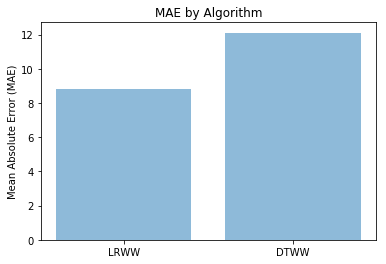

In [40]:
plt.bar(y_pos, comparisonDictWW['MeanAbsErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE by Algorithm')

Text(0.5,1,'MSE by Algorithm')

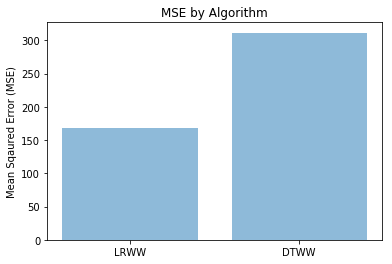

In [41]:
plt.bar(y_pos, comparisonDictWW['MeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Sqaured Error (MSE)')
plt.title('MSE by Algorithm')

Text(0.5,1,'RMSE by Algorithm')

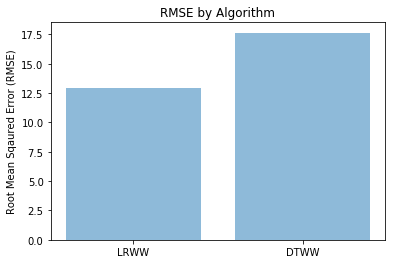

In [42]:
plt.bar(y_pos, comparisonDictWW['RootMeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Root Mean Sqaured Error (RMSE)')
plt.title('RMSE by Algorithm')

Text(0.5,1,'MAE With and Without Weather')

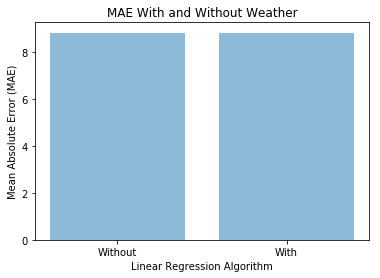

In [52]:
plt.bar(y_pos, [comparisonDict['MeanAbsErr'][0],comparisonDictWW['MeanAbsErr'][0]], align='center', alpha=0.5)
plt.xticks(y_pos, ('Without', 'With'))
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Linear Regression Algorithm')
plt.title('MAE With and Without Weather')

Text(0.5,1,'MSE With and Without Weather')

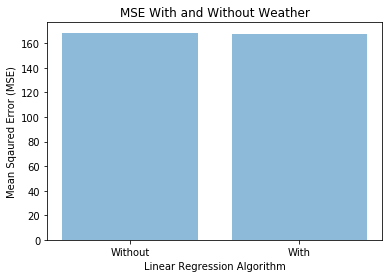

In [53]:
plt.bar(y_pos, [comparisonDict['MeanSquErr'][0],comparisonDictWW['MeanSquErr'][0]], align='center', alpha=0.5)
plt.xticks(y_pos, ('Without', 'With'))
plt.ylabel('Mean Sqaured Error (MSE)')
plt.xlabel('Linear Regression Algorithm')
plt.title('MSE With and Without Weather')

Text(0.5,1,'RMSE With and Without Weather')

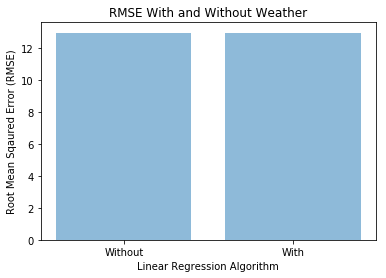

In [54]:
plt.bar(y_pos, [comparisonDict['RootMeanSquErr'][0],comparisonDictWW['RootMeanSquErr'][0]], align='center', alpha=0.5)
plt.xticks(y_pos, ('Without', 'With'))
plt.ylabel('Root Mean Sqaured Error (RMSE)')
plt.xlabel('Linear Regression Algorithm')
plt.title('RMSE With and Without Weather')

Text(0.5,1,'MAE With and Without Weather')

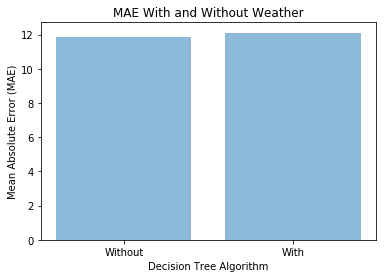

In [55]:
plt.bar(y_pos, [comparisonDict['MeanAbsErr'][1],comparisonDictWW['MeanAbsErr'][1]], align='center', alpha=0.5)
plt.xticks(y_pos, ('Without', 'With'))
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Decision Tree Algorithm')
plt.title('MAE With and Without Weather')

Text(0.5,1,'MSE With and Without Weather')

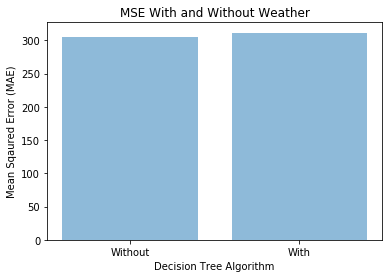

In [56]:
plt.bar(y_pos, [comparisonDict['MeanSquErr'][1],comparisonDictWW['MeanSquErr'][1]], align='center', alpha=0.5)
plt.xticks(y_pos, ('Without', 'With'))
plt.ylabel('Mean Sqaured Error (MAE)')
plt.xlabel('Decision Tree Algorithm')
plt.title('MSE With and Without Weather')

Text(0.5,1,'RMSE With and Without Weather')

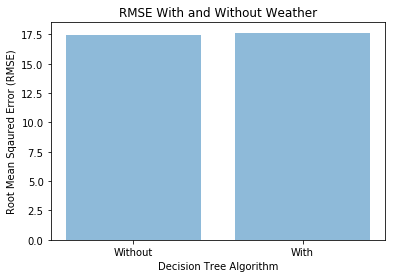

In [57]:
plt.bar(y_pos, [comparisonDict['RootMeanSquErr'][1],comparisonDictWW['RootMeanSquErr'][1]], align='center', alpha=0.5)
plt.xticks(y_pos, ('Without', 'With'))
plt.ylabel('Root Mean Sqaured Error (RMSE)')
plt.xlabel('Decision Tree Algorithm')
plt.title('RMSE With and Without Weather')

Would like to do next
- analyze more features
- see how features are being weighted
- try different algorithms
- look at more error metrics (AUC)
- if this was for enterprise (load into database, use SQL to join/clean, set up API for interfacing with model: maintaining, predicting)